# Deep Learning for tensiometry of pendant drop

### Import necessary packages and self-defined classes

In [1]:
# pyplot
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
# Test/Train data split
from functools import lru_cache
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import logging
# sklearn
from sklearn import preprocessing
# os
import os
# warnings
import warnings
warnings.filterwarnings('ignore')
# random
import random
# math
import math
import scipy.interpolate
# self-defined model
from model_pic import *
from model_cal import *
import pandas as pd

#PictureNet
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split

## Dataset loading and preprocessing

In [3]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[:validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
    
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train dataloader')
        self.train_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing validation dataloader')
        self.val_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing test dataloader')
        self.test_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

===================================

### Load data for PhysicsNet

In [4]:
data_matrix_points = pd.read_csv("Data_uniform/Edge_points.csv", header= None)
data_matrix_spline = pd.read_csv("Data_uniform/Spline.csv", header= None)
print(data_matrix_points)
# print(data_matrix_spline)

# Make the droplet dataset class based on data_matrix
class Droplet_data_set(Dataset):
    def __init__(self,dataInput):
        x = dataInput.iloc[0:,3:].values
        y = dataInput.iloc[0:,0:2].values
        # x = np.random.normal(x,0.01)
        y0 = dataInput.iloc[:,0].values
        y1 = dataInput.iloc[:,1].values
        
        # Plot surface tension histogram
        n, bins, patches = plt.hist(x=y0, bins='auto', color='#0504aa',
                                    alpha=0.7, rwidth=0.85)
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Surface Tension[mN/m]')
        plt.ylabel('Frequency')
        plt.title('Occurence of data per Surface Tension')\

        # Plot volume histogram
        # n, bins, patches = plt.hist(x=y1, bins='auto', color='#0504aa',
        #                             alpha=0.7, rwidth=0.85)
        # plt.grid(axis='y', alpha=0.75)
        # plt.xlabel('Volume[mm^3]')
        # plt.ylabel('Frequency')
        # plt.title('Occurence of data per Volume')

        self.x_train = torch.tensor(x,dtype=torch.float32)
        self.y_train = torch.tensor(y,dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.x_train[idx],self.y_train[idx]
    
    def __len__(self):
         return len(self.y_train)
        

        0         1          2             3         4         5         6    \
0      15.1   5.10061  14.150364 -4.464245e-24  0.031518  0.062998  0.094404   
1      15.1   5.20122  13.846032  7.555379e-24  0.031876  0.063713  0.095474   
2      15.1   5.30183  13.542532  2.339297e-23  0.032235  0.064430  0.096546   
3      15.1   5.40244  13.239690 -1.287495e-23  0.032596  0.065149  0.097622   
4      15.1   5.50305  12.937316  2.640561e-25  0.032957  0.065871  0.098701   
...     ...       ...        ...           ...       ...       ...       ...   
24742  86.1  25.28098  68.539411  9.590440e-26  0.062687  0.125280  0.187688   
24743  86.1  25.81469  67.593048 -1.411544e-26  0.063329  0.126561  0.189606   
24744  86.1  26.34840  66.662881 -2.293179e-25  0.063968  0.127837  0.191515   
24745  86.1  26.88211  65.747951 -1.514069e-24  0.064605  0.129108  0.193416   
24746  86.1  27.41582  64.847338 -7.083356e-25  0.065239  0.130375  0.195312   

            7         8         9    ..

Create and splite the dataset for edge point model

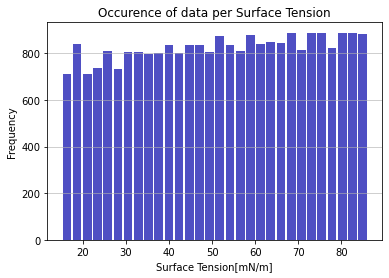

In [5]:
my_data_set_points = Droplet_data_set(data_matrix_points)
split_points = DataSplit(my_data_set_points, shuffle=True)  # Split the single dataset into 3 datasets for training, test and validation.
train_loader_points, val_loader_points, test_loader_points = split_points.get_split(batch_size=512, num_workers=0)

Create and splite the dataset for spline model

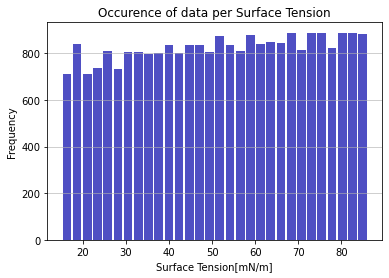

In [19]:
my_data_set_spline = Droplet_data_set(data_matrix_spline)
split_spline = DataSplit(my_data_set_spline, shuffle=True)  # Split the single dataset into 3 datasets for training, test and validation.
train_loader_spline, val_loader_spline, test_loader_spline = split_spline.get_split(batch_size=512, num_workers=0)

===========================================

### Load data for PictureNet
Read image from files

In [7]:
train_img = []
data_matrix_points = pd.read_csv("Data_uniform/Edge_points.csv", header= None)
data_matrix_spline = pd.read_csv("Data_uniform/Spline.csv", header= None)
data_image_points = data_matrix_points  
data_image_spline = data_matrix_spline

for img_name in data_image_points.iloc[0:,3:].index + 1:      # modify the number depends on size of dataset
    # defining the image path
    image_path = 'Data_uniform/Data_Spline/' + str(img_name) + '.png'      # modify the path depends on which dataset
    # reading the image
    img = imread(image_path, as_gray=True)
    img = img[4:-4, 4:-4]  #crop 
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

Plot a single image for viewing

Current image = 2842
Picture size = (82, 77)


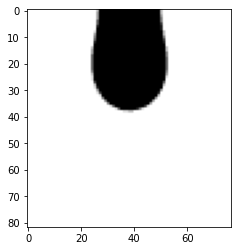

In [8]:
rand = random.randint(1, 27000)
print("Current image =", rand)
print("Picture size =", train_img[rand].shape)
plt.imshow(train_img[rand], cmap='gray')


Define the function

In [9]:
# Split and transfer the data from list to torch format
def split_n_transfer(x, y):
    # Points data split
    train_x_pic, rem_x_pic, train_y_pic, rem_y_pic = train_test_split(x, y, test_size = 0.2)    # default shuffle = True
    val_x_pic, test_x_pic, val_y_pic, test_y_pic = train_test_split(rem_x_pic, rem_y_pic, test_size = 0.5)

    # converting the train images of points and targets into torch format
    train_x_pic = train_x_pic.reshape(len(train_x_pic), 1, 82, 77)
    train_x_pic = torch.from_numpy(train_x_pic)
    train_y_pic = torch.from_numpy(train_y_pic)

    # converting the val images and target points into torch format
    val_x_pic = val_x_pic.reshape(len(val_x_pic), 1, 82, 77)
    val_x_pic = torch.from_numpy(val_x_pic)
    val_y_pic = torch.from_numpy(val_y_pic)
    # print(val_x_pic.shape, val_y_pic.shape)

    # converting the test images and targets into torch format for points
    test_x_pic = test_x_pic.reshape(len(test_x_pic), 1, 82, 77)
    test_x_pic  = torch.from_numpy(test_x_pic)
    test_y_pic = torch.from_numpy(test_y_pic)
    # print(test_x_pic.shape, test_y_pic.shape)
    
    return train_x_pic, train_y_pic, val_x_pic, val_y_pic, test_x_pic, test_y_pic

# converting the dataset into mini-batch dataset (input 4D -> 5D and 2D -> 3D)
def batch_transform(dataset, batch_size=512):
    batch = []
    batch_num = math.ceil(len(dataset)/batch_size)
    for i in range(batch_num):
        if len(dataset) == 4:
            if i < batch_num-1:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :, :, :])
            else:
                batch.append(dataset[i*batch_size:, :, :, :])
        else:
            if i < batch_num-1:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :])
            else:
                batch.append(dataset[i*batch_size:, :])
    return batch

# converting all raw datasets into batch datasets in the same time
def batch_all(train_x, train_y, val_x, val_y, test_x, test_y):
    train_x_pic = batch_transform(train_x)
    train_y_pic = batch_transform(train_y)
    val_x_pic = batch_transform(val_x)
    val_y_pic = batch_transform(val_y)
    test_x_pic = batch_transform(test_x)
    test_y_pic = batch_transform(test_y)
    return train_x_pic, train_y_pic, val_x_pic, val_y_pic, test_x_pic, test_y_pic

Create and splite the dataset for edge point model

In [10]:
# converting the list to numpy array
train_x_pic = np.array(train_img)
train_y_pic_points = data_image_points.iloc[0:,3:].values

train_x_pic_points, train_y_pic_points, val_x_pic_points, val_y_pic_points, test_x_pic_points, test_y_pic_points = \
    split_n_transfer(train_x_pic, train_y_pic_points)

train_x_pic_points, train_y_pic_points, val_x_pic_points, val_y_pic_points, test_x_pic_points, test_y_pic_points = \
    batch_all(train_x_pic_points, train_y_pic_points, val_x_pic_points, val_y_pic_points, test_x_pic_points, test_y_pic_points)
    
print(len(train_x_pic_points), len(train_y_pic_points), len(val_x_pic_points), len(val_y_pic_points), len(test_x_pic_points), len(test_y_pic_points))


39 39 5 5 5 5


Create and splite the dataset for spline model

In [18]:
# converting the list to numpy array
train_x_pic = np.array(train_img)
train_y_pic_spline = data_image_spline.iloc[0:,3:].values

train_x_pic_spline, train_y_pic_spline, val_x_pic_spline, val_y_pic_spline, test_x_pic_spline, test_y_pic_spline = \
    split_n_transfer(train_x_pic, train_y_pic_spline)

train_x_pic_spline, train_y_pic_spline, val_x_pic_spline, val_y_pic_spline, test_x_pic_spline, test_y_pic_spline = \
    batch_all(train_x_pic_spline, train_y_pic_spline, val_x_pic_spline, val_y_pic_spline, test_x_pic_spline, test_y_pic_spline)

print(len(train_x_pic_spline), len(train_y_pic_spline), len(val_x_pic_spline), len(val_y_pic_spline), len(test_x_pic_spline), len(test_y_pic_spline))

39 39 5 5 5 5


Import test dataset to compare two models

In [12]:
data_test_matrix_spline = pd.read_csv("Data_uniform/Test_Spline_Data.csv", header= None)
test_img = []

for img_name in data_test_matrix_spline.iloc[0:,3:].index + 1:      # modify the number depends on size of dataset
    # defining the image path
    image_path = 'Data_uniform/Data_Test_No_Hole/' + str(img_name) + '.png'      # modify the path depends on which dataset
    # reading the image
    img = imread(image_path, as_gray=True)
    img = img[4:-4, 4:-4]  #crop 
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    test_img.append(img)

test_x_pic = np.array(test_img)
test_y_pic = data_test_matrix_spline.iloc[0:,3:].values

#Convert to tensor
test_x_pic = test_x_pic.reshape(len(test_x_pic), 1, 82, 77)
test_x_pic  = torch.from_numpy(test_x_pic)
test_y_pic = torch.from_numpy(test_y_pic)


==============================

### Deside to apply host or device


In [13]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


## Define the functions for models

In [14]:
def loss_cal_phiysics(loss_list, model, loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def loss_cal_picture(loss_list, model, x_dataset, y_dataset):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t in range(len(x_dataset)):
            x = x_dataset[t]
            y = y_dataset[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def prediction(model, x):   # only a batch
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float32)
        score = torch.Tensor.cpu(model(x))
    return score

def model_selection(model, path, loss, epoch_current, epoch_ref, loss_ref):
    loss_best = loss_ref
    epoch_best = epoch_ref
    if epoch_current == 0 and ~(os.path.isdir(path)):
            loss_current = loss[epoch_current]
            loss_best = loss[epoch_current]
            torch.save(model, path)
    else:
        loss_current = loss[epoch_current]
        if loss_current <= (loss_best * 1.1):   # 10% margin to get better fitting but a bit more loss
            loss_best = loss_current
            epoch_best = epoch_current
            torch.save(model, path)
    return loss_best, epoch_best

def train_physics(model, optimizer, epochs=1, model_input=0):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0
    
    # model selection depends on data type
    if model_input == 0:
        train_loader = train_loader_points
        val_loader = val_loader_points
        PATH_CAL = os.path.join(os.getcwd(), "model_cal_points.pt")
    elif model_input == 1:
        train_loader = train_loader_spline
        val_loader = val_loader_spline
        PATH_CAL = os.path.join(os.getcwd(), "model_cal_spline.pt")
    else:
        ValueError("Incorrect input: 0 for edge point model, 1 for spline model")

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x = x.reshape(len(x), 1, 1, -1)     # reshape to 4D data for formal input of model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_phiysics(loss_train, model, train_loader)
        loss_cal_phiysics(loss_val, model, val_loader)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))

        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_CAL, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()

def train_picture(model, optimizer, epochs=1, model_input=0):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0

    # model selection depends on data type
    if model_input == 0:
        train_x_pic = train_x_pic_points
        train_y_pic = train_y_pic_points
        val_x_pic = val_x_pic_points
        val_y_pic = val_y_pic_points
        PATH_PIC = os.path.join(os.getcwd(), "model_pic_points.pt")
    elif model_input == 1:
        train_x_pic = train_x_pic_spline
        train_y_pic = train_y_pic_spline
        val_x_pic = val_x_pic_spline
        val_y_pic = val_y_pic_spline
        PATH_PIC = os.path.join(os.getcwd(), "model_pic_spline.pt")
    else:
        ValueError("Incorrect input: 0 for edge point model, 1 for spline model")

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(len(train_x_pic)):
            model.train()  # put model to training mode
            x = train_x_pic[t]
            y = train_y_pic[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_picture(loss_train, model, train_x_pic, train_y_pic)
        loss_cal_picture(loss_val, model, val_x_pic, val_y_pic)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
        
        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_PIC, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())

    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()


## Train PhysicsNet Edge Points

epoch 1: train_loss = 1759.7687, val_loss = 2243.2526
epoch 2: train_loss = 1732.6026, val_loss = 2210.9167
epoch 3: train_loss = 1663.7901, val_loss = 2123.0363
epoch 4: train_loss = 1654.8246, val_loss = 2108.5620
epoch 5: train_loss = 1579.7111, val_loss = 2012.1445
epoch 6: train_loss = 1529.1479, val_loss = 1951.0392
epoch 7: train_loss = 1453.8305, val_loss = 1850.1917
epoch 8: train_loss = 1339.5262, val_loss = 1706.2493
epoch 9: train_loss = 1330.1889, val_loss = 1691.0184
epoch 10: train_loss = 1060.2900, val_loss = 1351.8275
epoch 11: train_loss = 1087.1750, val_loss = 1380.4740
epoch 12: train_loss = 1160.1654, val_loss = 1478.8343
epoch 13: train_loss = 1002.1445, val_loss = 1273.4273
epoch 14: train_loss = 855.4693, val_loss = 1086.9415
epoch 15: train_loss = 785.3074, val_loss = 997.0133
epoch 16: train_loss = 779.8744, val_loss = 992.4049
epoch 17: train_loss = 612.2734, val_loss = 781.3630
epoch 18: train_loss = 525.0823, val_loss = 674.7295
epoch 19: train_loss = 493.8

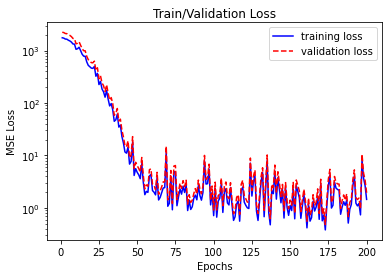

In [15]:
in_channel = 160
node_1 = 512
node_2 = 512
node_3 = 256
node_4 = 256
node_5 = 64
node_6 = 16
out_channel = 2

learning_rate = 1e-3

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, node_5, node_6, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 200

# 0 indicates edge points 1 indicates spline
train_physics(model_physics, optimizer, epoch, 0)

## Train PhysicsNet spline

epoch 1: train_loss = 1777.9764, val_loss = 2295.6217
epoch 2: train_loss = 1732.0377, val_loss = 2232.9743
epoch 3: train_loss = 1683.8959, val_loss = 2171.6916
epoch 4: train_loss = 1601.8080, val_loss = 2069.5951
epoch 5: train_loss = 1558.3007, val_loss = 2013.6006
epoch 6: train_loss = 1557.1023, val_loss = 2011.8927
epoch 7: train_loss = 1415.7449, val_loss = 1825.0422
epoch 8: train_loss = 1439.0800, val_loss = 1857.1418
epoch 9: train_loss = 1269.9490, val_loss = 1639.9587
epoch 10: train_loss = 1240.7078, val_loss = 1600.6590
epoch 11: train_loss = 1125.9246, val_loss = 1453.7746
epoch 12: train_loss = 1069.9176, val_loss = 1380.0120
epoch 13: train_loss = 975.7454, val_loss = 1262.4614
epoch 14: train_loss = 928.4054, val_loss = 1201.8454
epoch 15: train_loss = 820.9689, val_loss = 1059.2130
epoch 16: train_loss = 824.1910, val_loss = 1064.7651
epoch 17: train_loss = 691.5708, val_loss = 891.0278
epoch 18: train_loss = 790.4203, val_loss = 1019.6008
epoch 19: train_loss = 556

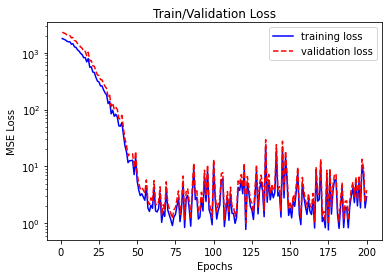

In [20]:
in_channel = 22
node_1 = 512
node_2 = 512
node_3 = 256
node_4 = 256
node_5 = 64
node_6 = 16
out_channel = 2

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, node_5, node_6, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 200

# 0 indicates edge points 1 indicates spline
train_physics(model_physics, optimizer, epoch, 1)

<font color=red>
It seems like more points we have, small oscillation we get.<br>
Instead of taking the polynomial coefficients as input, transfer coefficients into points.
</font>

### Retrain with SGD

epoch 1: train_loss = 0.3081, val_loss = 0.3919
epoch 2: train_loss = 0.1821, val_loss = 0.2330
epoch 3: train_loss = 0.4124, val_loss = 0.5234
epoch 4: train_loss = 0.2117, val_loss = 0.2707
epoch 5: train_loss = 0.1880, val_loss = 0.2358
epoch 6: train_loss = 0.1878, val_loss = 0.2407
epoch 7: train_loss = 0.1819, val_loss = 0.2336
epoch 8: train_loss = 0.1922, val_loss = 0.2439
epoch 9: train_loss = 0.1762, val_loss = 0.2202
epoch 10: train_loss = 0.2517, val_loss = 0.3067
epoch 11: train_loss = 0.2229, val_loss = 0.2856
epoch 12: train_loss = 0.1425, val_loss = 0.1802
epoch 13: train_loss = 0.1389, val_loss = 0.1801
epoch 14: train_loss = 0.1448, val_loss = 0.1801
epoch 15: train_loss = 0.2734, val_loss = 0.3517
epoch 16: train_loss = 0.1857, val_loss = 0.2279
epoch 17: train_loss = 0.2804, val_loss = 0.3552
epoch 18: train_loss = 0.1952, val_loss = 0.2511
epoch 19: train_loss = 0.1639, val_loss = 0.2006
epoch 20: train_loss = 0.1626, val_loss = 0.2098
epoch 21: train_loss = 0.1430

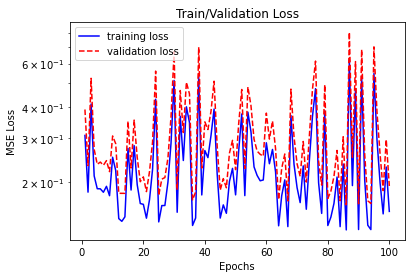

In [23]:
#PATH_CAL = os.path.join(os.getcwd(), "model_cal_points.pt")
PATH_CAL = os.path.join(os.getcwd(), "model_cal_spline.pt")

model_physics_trained = torch.load(PATH_CAL)

learning_rate = 1e-4

optimizer = optim.SGD(model_physics_trained.parameters(), lr=learning_rate)
epoch = 100

# 0 indicates edge points 1 indicates spline
train_physics(model_physics_trained, optimizer, epoch, 1)

### Visualization of outcomes
Edge Point Model

In [24]:
PATH_CAL_POINTS = os.path.join(os.getcwd(), "model_cal_points.pt")

model_physics_trained_points = torch.load(PATH_CAL_POINTS)

examples = enumerate(test_loader_points)
_, (x_test_points, y_test_points) = next(examples)

score_example_points = prediction(model_physics_trained_points, x_test_points)

# Print only 8 data samples for comparison
print("Ground Truths     =", y_test_points[:8])
print("Prediction Points =", score_example_points[:8].reshape(8, 2))

Ground Truths     = tensor([[43.6000, 11.3126],
        [38.4000, 17.8652],
        [26.7000, 12.7116],
        [57.3000, 21.1113],
        [85.0000, 39.7820],
        [67.9000, 30.3614],
        [29.8000,  8.9959],
        [34.0000, 12.5565]])
Prediction Points = tensor([[43.5936, 11.8971],
        [38.5528, 17.8267],
        [27.2363, 12.6879],
        [57.7407, 21.5136],
        [83.5477, 38.4522],
        [67.0839, 30.2950],
        [29.8511,  9.1683],
        [34.1378, 12.8571]])


Spline Model

In [25]:
PATH_CAL_SPLINE = os.path.join(os.getcwd(), "model_cal_spline.pt")

model_physics_trained_spline = torch.load(PATH_CAL_SPLINE)

examples = enumerate(test_loader_spline)
_, (x_test_spline, y_test_spline) = next(examples)

score_example_spline = prediction(model_physics_trained_spline, x_test_spline)

# Print only 8 data samples for comparison
print("Ground Truths     =", y_test_spline[:8])
print("Prediction Spline =", score_example_spline[:8].reshape(8, 2))

Ground Truths     = tensor([[67.0000, 25.0256],
        [24.3000,  9.3884],
        [62.6000, 28.4216],
        [31.7000, 13.2767],
        [65.2000, 22.4675],
        [30.3000, 12.3465],
        [49.5000, 20.5225],
        [65.9000, 27.5770]])
Prediction Spline = tensor([[67.0036, 24.9800],
        [24.2915,  9.6825],
        [62.2323, 28.5067],
        [31.8484, 13.6613],
        [64.8099, 22.6820],
        [30.5475, 12.8973],
        [49.9249, 20.3312],
        [65.4609, 27.5722]])


## Train PictureNet edge points

epoch 1: train_loss = 0.4926, val_loss = 0.6010
epoch 2: train_loss = 0.3933, val_loss = 0.4798
epoch 3: train_loss = 0.1556, val_loss = 0.1886
epoch 4: train_loss = 0.0107, val_loss = 0.0130
epoch 5: train_loss = 0.0212, val_loss = 0.0256
epoch 6: train_loss = 0.0044, val_loss = 0.0053
epoch 7: train_loss = 0.2499, val_loss = 0.3043
epoch 8: train_loss = 0.0037, val_loss = 0.0045
epoch 9: train_loss = 0.0816, val_loss = 0.0997
epoch 10: train_loss = 0.0389, val_loss = 0.0472
epoch 11: train_loss = 0.0042, val_loss = 0.0050
epoch 12: train_loss = 0.0769, val_loss = 0.0936
epoch 13: train_loss = 0.0014, val_loss = 0.0018
epoch 14: train_loss = 0.0225, val_loss = 0.0274
epoch 15: train_loss = 0.0093, val_loss = 0.0114
epoch 16: train_loss = 0.0413, val_loss = 0.0500
epoch 17: train_loss = 0.0857, val_loss = 0.1051
epoch 18: train_loss = 0.0023, val_loss = 0.0028
epoch 19: train_loss = 0.0684, val_loss = 0.0835
epoch 20: train_loss = 8.0947, val_loss = 9.8737
epoch 21: train_loss = 48.541

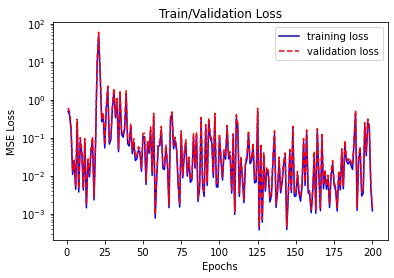

In [26]:
in_channel = 1
channel_1 = 16
channel_2 = 32
channel_3 = 64
node_1 = 1024
node_2 = 1024
out_channel = 160

learning_rate = 1e-3

model_picture = PictureNet(in_channel, channel_1, channel_2, channel_3, node_1, node_2, out_channel)
optimizer = optim.Adam(model_picture.parameters(), lr=learning_rate)
epoch = 200

# 0 indicates edge points 1 indicates spline
train_picture(model_picture, optimizer, epoch, 0)

## Train PictureNet for spline

epoch 1: train_loss = 1.1751, val_loss = 1.4303
epoch 2: train_loss = 0.9491, val_loss = 1.1572
epoch 3: train_loss = 0.0165, val_loss = 0.0202
epoch 4: train_loss = 0.0072, val_loss = 0.0088
epoch 5: train_loss = 0.0043, val_loss = 0.0052
epoch 6: train_loss = 0.0043, val_loss = 0.0052
epoch 7: train_loss = 0.0050, val_loss = 0.0061
epoch 8: train_loss = 0.0028, val_loss = 0.0034
epoch 9: train_loss = 0.0024, val_loss = 0.0029
epoch 10: train_loss = 0.0011, val_loss = 0.0014
epoch 11: train_loss = 0.0011, val_loss = 0.0013
epoch 12: train_loss = 0.0008, val_loss = 0.0009
epoch 13: train_loss = 0.0055, val_loss = 0.0067
epoch 14: train_loss = 0.0002, val_loss = 0.0002
epoch 15: train_loss = 0.0005, val_loss = 0.0006
epoch 16: train_loss = 0.0014, val_loss = 0.0017
epoch 17: train_loss = 0.1488, val_loss = 0.1811
epoch 18: train_loss = 0.0015, val_loss = 0.0018
epoch 19: train_loss = 0.0015, val_loss = 0.0018
epoch 20: train_loss = 0.0009, val_loss = 0.0011
epoch 21: train_loss = 0.0039

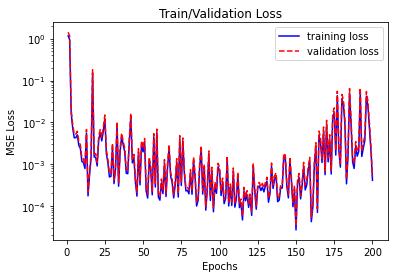

In [29]:
in_channel = 1
channel_1 = 16
channel_2 = 32
channel_3 = 64
node_1 = 1024
node_2 = 1024
out_channel = 22

learning_rate = 1e-3

model_picture = PictureNet(in_channel, channel_1, channel_2, channel_3, node_1, node_2, out_channel)
optimizer = optim.Adam(model_picture.parameters(), lr=learning_rate)
epoch = 200

# 0 indicates edge points 1 indicates spline
train_picture(model_picture, optimizer, epoch, 1)

### Retrain with SGD

In [34]:
#PATH_PIC = os.path.join(os.getcwd(), "model_pic_points.pt")
PATH_PIC = os.path.join(os.getcwd(), "model_pic_spline.pt")

model_picture_trained = torch.load(PATH_PIC)

learning_rate = 1e-3

optimizer = optim.SGD(model_picture_trained.parameters(), lr=learning_rate)
epoch = 20

# 0 indicates edge points 1 indicates spline
train_picture(model_picture_trained, optimizer, epoch, 0)

RuntimeError: CUDA out of memory. Tried to allocate 198.00 MiB (GPU 0; 4.00 GiB total capacity; 2.25 GiB already allocated; 0 bytes free; 2.33 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Visualization of outcomes

In [35]:
# testing cell for better viewing the length
train_x_pic_points, train_y_pic_points

print(len(train_x_pic_points))
print(train_x_pic_points[0].shape)
print(train_y_pic_points[0].shape)

39
torch.Size([512, 1, 82, 77])
torch.Size([512, 160])


Edge Point Model

In [36]:
PATH_PIC = os.path.join(os.getcwd(), "model_pic_points.pt")
model_picture_trained = torch.load(PATH_PIC)


rand1 = random.randint(0, len(test_x_pic)-1)
#rand2 = random.randint(0, 511)

print("current testing image =", rand1)

score_pic = prediction(model_picture_trained, test_x_pic[rand1].reshape(1, 1, 82, 77))

# Print all points out for viewing
# for num in range(len(test_y_pic_points[rand1][rand2])):
#     print(num+1, ": Ground Truths =", test_y_pic_points[rand1][rand2][num].item(), ", Prediction =", score_pic[0, num].item())


current testing image = 50


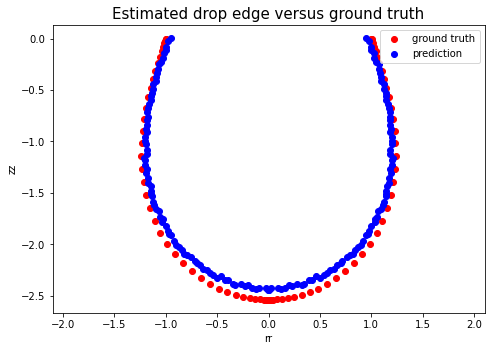

In [38]:
data_YC = pd.read_csv("Data_uniform/YC.csv", header= None)
YC = torch.Tensor(data_YC.values)

# scattering points for ground truth
x_gt_pos = torch.matmul(YC ,test_y_pic[rand1][0:11].float()) 
y_gt_pos = torch.matmul(YC ,test_y_pic[rand1][11:22].float()) 
x_gt_neg = -torch.flip(x_gt_pos, [0])
y_gt_neg = torch.flip(y_gt_pos, [0])
x_gt = torch.cat((x_gt_neg, x_gt_pos))
y_gt = torch.cat((y_gt_neg, y_gt_pos))

# scattering points for prediction
x_pred_pos = score_pic[0, 0:80]
y_pred_pos = score_pic[0, 80:160]
x_pred_neg = -torch.flip(x_pred_pos, [0])
y_pred_neg = torch.flip(y_pred_pos, [0])
x_pred = torch.cat((x_pred_neg, x_pred_pos))
y_pred = torch.cat((y_pred_neg, y_pred_pos))

# plotting
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.set_xlim(0,3)
a1.set_title("Estimated drop edge versus ground truth", fontsize = 15)
plt.scatter(x_gt, y_gt, c="red", label="ground truth")
plt.scatter(x_pred, y_pred, c="blue", label="prediction")
plt.xlabel("rr")
plt.ylabel("zz")
plt.legend()
plt.axis('equal')
plt.show()

Spline Model Interpolation points

In [39]:
#Number of interpolation points to use for PhysicsNet and plotting
Num_points = 80

In [40]:
#Load YC matrix for point values and s data for interpolation
data_s = pd.read_csv("Data_uniform/s.csv", header= None)

s = data_s.values
s = s.reshape(1,len(s))
#Interpolate to 160 points using a linear vector for s
ss = np.linspace(s[0][0],s[0][-1],Num_points)

Plot difference Spline and ground truth

In [41]:
PATH_PIC = os.path.join(os.getcwd(), "model_pic_spline.pt")
model_picture_trained = torch.load(PATH_PIC)


print("current testing image =", rand1)

score_pic_pred = prediction(model_picture_trained, test_x_pic[rand1].reshape(1, 1, 82, 77))

#Multiply the found Chebyshev coefficients with YC matrix to obtain edge points
score_pic_r = torch.matmul(YC ,score_pic_pred[0, 0:11]) 
score_pic_z = torch.matmul(YC ,score_pic_pred[0, 11:22])

#Do polynominal fitting through data to get more data points
score_pic_r = np.polyval( np.polyfit(s[0],score_pic_r.numpy(),15), ss)
score_pic_z = np.polyval( np.polyfit(s[0],score_pic_z.numpy(),15), ss)

#Convert back to torch
score_pic_r = torch.tensor(score_pic_r)
score_pic_z = torch.tensor(score_pic_z)


test_y_pic_r = torch.matmul(YC ,test_y_pic[rand1][0:11].float()) 
test_y_pic_z = torch.matmul(YC ,test_y_pic[rand1][11:22].float()) 

#Do polynominal fitting through data to get more data points
test_y_pic_r = np.polyval( np.polyfit(s[0],test_y_pic_r.numpy(),15), ss)
test_y_pic_z = np.polyval( np.polyfit(s[0],test_y_pic_z.numpy(),15), ss)

#Convert back to torch
test_y_pic_r = torch.tensor(test_y_pic_r)
test_y_pic_z = torch.tensor(test_y_pic_z)

# Print all points out for viewing
# for num in range(len(test_y_pic_r)):
#    print(num+1, ": Ground Truths =", test_y_pic_z[num].item(), ", Prediction =", score_pic_z[num].item())


current testing image = 50


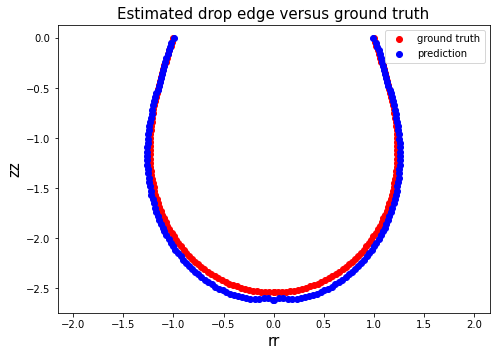

In [42]:
# scattering points for ground truth
gt_r_pos = test_y_pic_r
gt_r_neg = -torch.flip(test_y_pic_r, [0])
gt_z_pos = test_y_pic_z
gt_z_neg = torch.flip(test_y_pic_z, [0])
gt_r = torch.cat((gt_r_neg, gt_r_pos))
gt_z = torch.cat((gt_z_neg, gt_z_pos))

# scattering points for prediction
pred_r_pos = score_pic_r
pred_r_neg = -torch.flip(score_pic_r, [0])
pred_z_pos = score_pic_z
pred_z_neg = torch.flip(score_pic_z, [0])
pred_r = torch.cat((pred_r_neg, pred_r_pos))
pred_z = torch.cat((pred_z_neg, pred_z_pos))

# plotting
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.set_xlim(0,3)
a1.set_title("Estimated drop edge versus ground truth", fontsize = 15)
plt.scatter(gt_r, gt_z, c="red", label="ground truth")
plt.scatter(pred_r, pred_z, c="blue", label="prediction")

plt.xlabel("rr",fontsize = 15)
plt.ylabel("zz",fontsize = 15)
plt.legend()
plt.axis('equal')
plt.show()

### Evaluation between two model predictions

In [ ]:
# Edge Points -> x_gt, y_gt, x_pred, y_pred
# Spline -> gt_r, gt_z, pred_r, pred_z

l2_x_points = torch.sum(torch.pow((x_gt - x_pred), 2))
l2_y_points = torch.sum(torch.pow((y_gt - y_pred), 2))
l2_points = (l2_x_points + l2_y_points) / len(x_gt)
print("L2 norm of point =", l2_points.item())

l2_x_spline = torch.sum(torch.pow((gt_r - pred_r), 2))
l2_y_spline = torch.sum(torch.pow((gt_z - pred_z), 2))
l2_spline = (l2_x_spline + l2_y_spline) / len(gt_r)
print("L2 norm of spline =", l2_spline.item())

L2 norm of point = 0.02662239587949502
L2 norm of spline = 0.017126961185241218
